In [ ]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

In [82]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [83]:
x_train = x_train.reshape(x_train.shape[0], -1).astype(np.float32) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1).astype(np.float32) / 255.0

In [84]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


Xây dựng mô hình

In [85]:
def knn_predict(x_train, y_train, x_test, k=10):
    distances = np.einsum('ij,ij->i', x_train - x_test, x_train - x_test)  
    indices = np.argpartition(distances, k)[:k]  
    nearest_labels = y_train[indices]
    return np.bincount(nearest_labels).argmax()  


In [110]:
class SVM:
    def __init__(self, num_classes=10, num_features=784, lr=0.0001, reg_lambda=0.001, epochs=1000):

        self.num_classes = num_classes
        self.num_features = num_features
        self.lr = lr
        self.reg_lambda = reg_lambda
        self.epochs = epochs
        
        self.num_uncertain = 0
        # Khởi tạo trọng số W và bias b
        self.W = np.random.randn(self.num_classes, self.num_features) * 0.01
        self.b = np.zeros(self.num_classes)

    def compute_loss(self, X, y):
        n_samples = X.shape[0]
        total_loss = 0
        
        for i in range(n_samples):
            x_i = X[i]
            y_true = y[i]
            
            # Chuyển nhãn thành One-vs-Rest (-1 hoặc +1)
            y_ovr = np.where(np.arange(self.num_classes) == y_true, 1, -1)
            
            # Tính margin
            margins = 1 - y_ovr * (np.dot(self.W, x_i) + self.b)
            margins = np.maximum(0, margins)  # max(0, margin)
            
            # Tổng tổn thất cho tất cả class
            total_loss += np.sum(margins)
        
        # Thêm phần regularization
        total_loss /= n_samples  # Trung bình loss
        total_loss += (self.reg_lambda / 2) * np.sum(self.W ** 2)  # Regularization term
        return total_loss
    
    def train(self, X, y):

        n_samples = X.shape[0]

        for i in range(n_samples):
            x_i = X[i]
            y_true = y[i]
            
            # Chuyển nhãn thành One-vs-Rest (-1 hoặc +1)
            y_ovr = np.where(np.arange(self.num_classes) == y_true, 1, -1)
            
            # Tính margin: W * x + b
            margins = y_ovr * (np.dot(self.W, x_i) + self.b)
            
            for j in range(self.num_classes):
                if margins[j] < 1:  # Sai số lớn -> cần cập nhật
                    self.W[j] -= self.lr * (self.reg_lambda * self.W[j] - y_ovr[j] * x_i)
                    self.b[j] -= self.lr * (-y_ovr[j])
                else:  # Sai số nhỏ -> chỉ cần regularization
                    self.W[j] -= self.lr * (self.reg_lambda * self.W[j])
        
        for epoch in range(self.epochs):
            for i in range(n_samples):
                x_i = X[i]
                y_true = y[i]
                
                # Chuyển nhãn thành One-vs-Rest (-1 hoặc +1)
                y_ovr = np.where(np.arange(self.num_classes) == y_true, 1, -1)
                
                # Tính margin: W * x + b
                margins = y_ovr * (np.dot(self.W, x_i) + self.b)
                
                for j in range(self.num_classes):
                    if abs(margins[j]) < 1:  # Sai số lớn -> cần cập nhật
                        self.W[j] -= self.lr * (self.reg_lambda * self.W[j] - y_ovr[j] * x_i)
                        self.b[j] -= self.lr * (-y_ovr[j])
                    else:  # Sai số nhỏ -> chỉ cần regularization
                        self.W[j] -= self.lr * (self.reg_lambda * self.W[j])

            # In quá trình huấn luyện sau mỗi epoch
            loss = self.compute_loss(X, y)
            y_pred = self.predict(x_test, 0, 0)
            accuracy = np.mean(y_pred == y_test)
            print(f"Epoch {epoch+1}/{self.epochs} completed - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")

    def predict(self, X, lower_threshold, upper_threshold):
        scores = np.dot(self.W, X.T) + self.b[:, np.newaxis]
        predictions = np.argmax(scores, axis=0)
         # Tính độ tin cậy dựa trên margin
        margins = np.max(scores, axis=0) - np.sort(scores, axis=0)[-2]
        uncertain_indices = np.where((margins < upper_threshold) & (margins > lower_threshold))[0] 
        if len(uncertain_indices) > 0:
            self.num_uncertain = len(uncertain_indices)
            print(f"Số ảnh không chắc chắn: {self.num_uncertain}")
            if len(X) == 1:
                print(f"Dự đoán SVM: {predictions[0]}")
            for idx in uncertain_indices:
                predictions[idx] = knn_predict(x_train, y_train, X[idx])
        return predictions
    


In [111]:
svm_model = SVM(epochs=10)
svm_model.train(x_train, y_train)

Epoch 1/10 completed - Loss: 0.8865 - Accuracy: 0.8761
Epoch 2/10 completed - Loss: 0.8280 - Accuracy: 0.8831
Epoch 3/10 completed - Loss: 0.7959 - Accuracy: 0.8872
Epoch 4/10 completed - Loss: 0.7752 - Accuracy: 0.8904
Epoch 5/10 completed - Loss: 0.7601 - Accuracy: 0.8937
Epoch 6/10 completed - Loss: 0.7491 - Accuracy: 0.8945
Epoch 7/10 completed - Loss: 0.7402 - Accuracy: 0.8964
Epoch 8/10 completed - Loss: 0.7328 - Accuracy: 0.8965
Epoch 9/10 completed - Loss: 0.7267 - Accuracy: 0.8970
Epoch 10/10 completed - Loss: 0.7218 - Accuracy: 0.8977


In [112]:
y_pred = svm_model.predict(x_test, 0, 0)
accuracy = np.mean(y_pred == y_test)
print(f"accuracy: {accuracy:.4f}")

accuracy: 0.8977


In [113]:
improved_image = []
num_uncertain = []
for i in range(20):
    print(f"Range {i*0.1:.1f} - {(i+1)*0.1:.1f}")
    y_pred_temp = svm_model.predict(x_test, i*0.1, (i+1)*0.1)
    accuracy_temp = np.mean(y_pred_temp == y_test)
    num_uncertain.append(svm_model.num_uncertain)
    improved_image.append(round((accuracy_temp-accuracy)*10000))
    print(f"Số ảnh được cải thiện bằng KNN: {improved_image[i]}")
    print("---------------------------------------")

Range 0.0 - 0.1
Số ảnh không chắc chắn: 171
Số ảnh được cải thiện bằng KNN: 93
---------------------------------------
Range 0.1 - 0.2
Số ảnh không chắc chắn: 156
Số ảnh được cải thiện bằng KNN: 73
---------------------------------------
Range 0.2 - 0.3
Số ảnh không chắc chắn: 159
Số ảnh được cải thiện bằng KNN: 59
---------------------------------------
Range 0.3 - 0.4
Số ảnh không chắc chắn: 165
Số ảnh được cải thiện bằng KNN: 68
---------------------------------------
Range 0.4 - 0.5
Số ảnh không chắc chắn: 151
Số ảnh được cải thiện bằng KNN: 55
---------------------------------------
Range 0.5 - 0.6
Số ảnh không chắc chắn: 171
Số ảnh được cải thiện bằng KNN: 49
---------------------------------------
Range 0.6 - 0.7
Số ảnh không chắc chắn: 163
Số ảnh được cải thiện bằng KNN: 49
---------------------------------------
Range 0.7 - 0.8
Số ảnh không chắc chắn: 133
Số ảnh được cải thiện bằng KNN: 24
---------------------------------------
Range 0.8 - 0.9
Số ảnh không chắc chắn: 147
Số ả

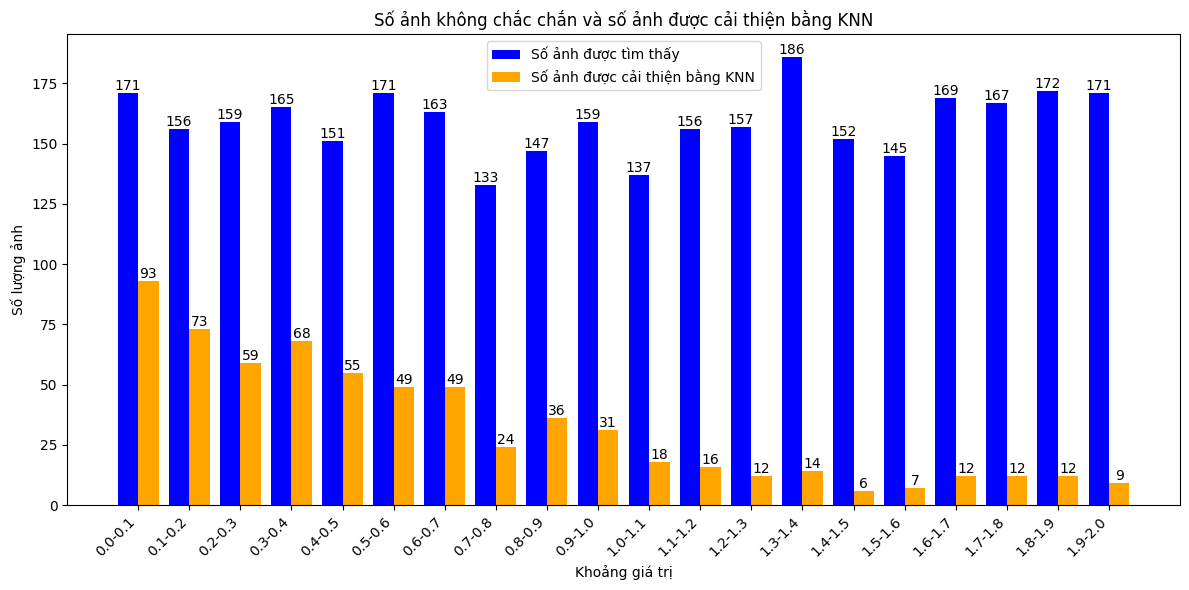

In [115]:
import matplotlib.pyplot as plt
import numpy as np

ranges = []
for i in range(20):
    ranges.append(f"{i*0.1:0.1f}-{(i+1)*0.1:0.1f}")


x = np.arange(len(ranges))  # Vị trí cột trên trục x
width = 0.4  # Độ rộng cột

fig, ax = plt.subplots(figsize=(12, 6))

# Vẽ cột
bars1 = ax.bar(x - width/2, num_uncertain, width, label="Số ảnh được tìm thấy", color='blue')
bars2 = ax.bar(x + width/2, improved_image, width, label="Số ảnh được cải thiện bằng KNN", color='orange')

# Hiển thị số liệu trên cột
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()}', ha='center', va='bottom', fontsize=10)

# Định dạng biểu đồ
ax.set_xlabel("Khoảng giá trị")
ax.set_ylabel("Số lượng ảnh")
ax.set_title("Số ảnh không chắc chắn và số ảnh được cải thiện bằng KNN")
ax.set_xticks(x)
ax.set_xticklabels(ranges, rotation=45, ha="right")  # Xoay nhãn trục x
ax.legend()

plt.tight_layout()
plt.show()


In [158]:
np.sum(improved_image[:10])

np.int64(537)

In [118]:
y_pred_0_1 = svm_model.predict(x_test, 0, 1)
accuracy_temp = np.mean(y_pred_0_1 == y_test)
print(f"Accuracy on test set: {accuracy_temp:.4f}")

Số ảnh không chắc chắn: 1575
Accuracy on test set: 0.9514


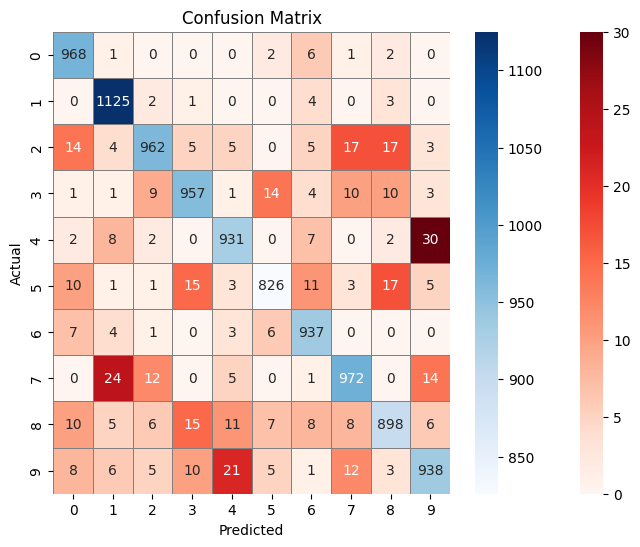

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_0_1)

# Tạo mặt nạ để giảm độ sáng của đường chéo chính
mask = np.eye(cm.shape[0], dtype=bool)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', mask=mask, linewidths=0.5, linecolor="gray")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', mask=~mask, linewidths=0.5, linecolor="gray")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Class 0: Precision = 0.9490, Recall = 0.9878, F1-score = 0.9680
Class 1: Precision = 0.9542, Recall = 0.9912, F1-score = 0.9723
Class 2: Precision = 0.9620, Recall = 0.9322, F1-score = 0.9469
Class 3: Precision = 0.9541, Recall = 0.9475, F1-score = 0.9508
Class 4: Precision = 0.9500, Recall = 0.9481, F1-score = 0.9490
Class 5: Precision = 0.9605, Recall = 0.9260, F1-score = 0.9429
Class 6: Precision = 0.9522, Recall = 0.9781, F1-score = 0.9650
Class 7: Precision = 0.9501, Recall = 0.9455, F1-score = 0.9478
Class 8: Precision = 0.9433, Recall = 0.9220, F1-score = 0.9325
Class 9: Precision = 0.9389, Recall = 0.9296, F1-score = 0.9343

Macro F1-score (trung bình tất cả lớp): 0.8954


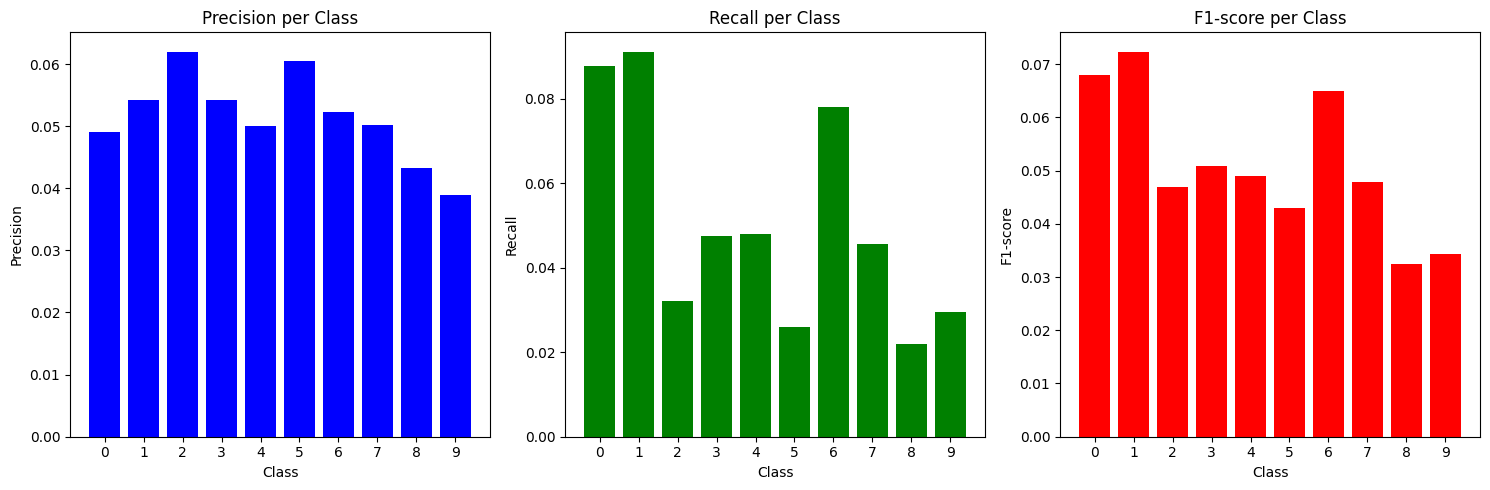

In [120]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Dự đoán nhãn
#y_pred = svm_model.predict(x_test,1.5)

# Tính Precision, Recall, F1-score cho từng lớp
precision = precision_score(y_test, y_pred_0_1, average=None)
recall = recall_score(y_test, y_pred_0_1, average=None)
f1 = f1_score(y_test, y_pred_0_1, average=None)

# In kết quả
for i in range(10):
    print(f"Class {i}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, F1-score = {f1[i]:.4f}")

# Tính trung bình toàn bộ các lớp
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"\nMacro F1-score (trung bình tất cả lớp): {macro_f1:.4f}")

# Trừ 90% từ các chỉ số
precision_adjusted = precision - 0.9
recall_adjusted = recall - 0.9
f1_adjusted = f1 - 0.9

# Số lớp
classes = np.arange(len(precision))

# Tạo biểu đồ
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision
axes[0].bar(classes, precision_adjusted, color='blue')
axes[0].set_title('Precision per Class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Precision')
axes[0].set_xticks(classes)
axes[0].set_xticklabels(classes)

# Recall
axes[1].bar(classes, recall_adjusted, color='green')
axes[1].set_title('Recall per Class')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Recall')
axes[1].set_xticks(classes)
axes[1].set_xticklabels(classes)

# F1-score
axes[2].bar(classes, f1_adjusted, color='red')
axes[2].set_title('F1-score per Class')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('F1-score')
axes[2].set_xticks(classes)
axes[2].set_xticklabels(classes)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

Số ảnh không chắc chắn: 1
Dự đoán SVM: 4
Dự đoán cuối cùng: 5
Nhãn thực tế: 5


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

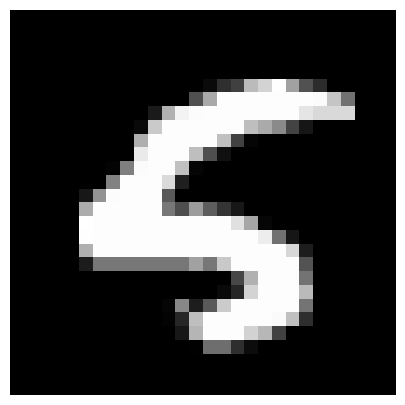

In [196]:
ran = random.randint(0,len(x_test))
y_prediction = svm_model.predict(np.array([x_test[ran]]), 0, 1)
print(f"Dự đoán cuối cùng: {y_prediction[0]}")
print(f"Nhãn thực tế: {y_test[ran]}")
fig, axes = plt.subplots(figsize=(10, 5))
axes.imshow(x_test[ran].reshape(28, 28), cmap="gray")
axes.axis("off")